# Overlay analysis

Overlay analyses are GIS operations in which two or more vector layers are
combined to produce new geometries. Typical overlay operations include *union*,
*intersection*, and *difference* - named after the result of the combination of
two layers.


![Four panels showing the union, intersection, symmetrical difference, and difference of two geometries.](images/overlay-operations_700x200px.svg)

**Figure:** Spatial overlay with two input vector layers (rectangle, circle). The resulting vector layer is displayed in green. *Source: [QGIS documentation](https://docs.qgis.org/latest/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html#figure-overlay-operations)*



In this tutorial, we will carry out an overlay analysis to select those polygon
cells of a grid dataset that lie within the city limits of Helsinki. For this
exercise, we use two input data sets: a grid of statistical polygons with the
travel time to the Helsinki railway station, covering the entire metropolitan
area (`helsinki_region_travel_times_to_railway_station.gpkg`) and a polygon
data set (with one feature) of the area the municipality of Helsinki covers
(`helsinki_municipality.gpkg`). Both files are in logically named subfolders
of the `DATA_DIRECTORY`.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
import geopandas

grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)

helsinki = geopandas.read_file(
    DATA_DIRECTORY / "helsinki_municipality" / "helsinki_municipality.gpkg"
)

Let’s do a quick overlay visualization of the two layers:

<Axes: >

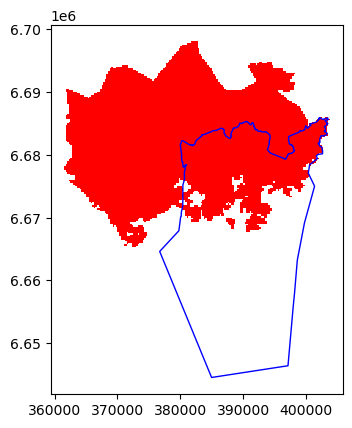

In [6]:
ax = grid.plot(facecolor='red')
helsinki.plot(ax=ax, facecolor="None", edgecolor='blue')


Here the grey area is the Travel Time Matrix - a data set that contains  13231
grid squares (13231 rows of data) that covers the Helsinki region, and the blue
area represents the municipality of Helsinki. Our goal is to conduct an overlay
analysis and select the geometries from the grid polygon layer that intersect
with the Helsinki municipality polygon.

When conducting overlay analysis, it is important to first check that the CRS
of the layers match. The overlay visualization indicates that everything should
be ok (the layers are plotted nicely on top of each other). However, let's
still check if the crs match using Python:

In [7]:
# Check the crs of the municipality polygon
helsinki.crs

<Projected CRS: EPSG:3067>
Name: EUREF-FIN / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: EUREF-FIN
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# Ensure that the CRS matches, if not raise an AssertionError
assert helsinki.crs == grid.crs, "CRS differs between layers!"

Indeed, they do. We are now ready to conduct an overlay analysis between these layers. 

We will create a new layer based on grid polygons that `intersect` with our
Helsinki layer. We can use a method `overlay()` of a `GeoDataFrame` to conduct
the overlay analysis that takes as an input 1) second GeoDataFrame, and 2)
parameter `how` that can be used to control how the overlay analysis is
conducted (possible values are `'intersection'`, `'union'`,
`'symmetric_difference'`, `'difference'`, and `'identity'`):

In [10]:
intersection = grid.overlay(helsinki, how="intersection")

Let's plot our data and see what we have:

<Axes: >

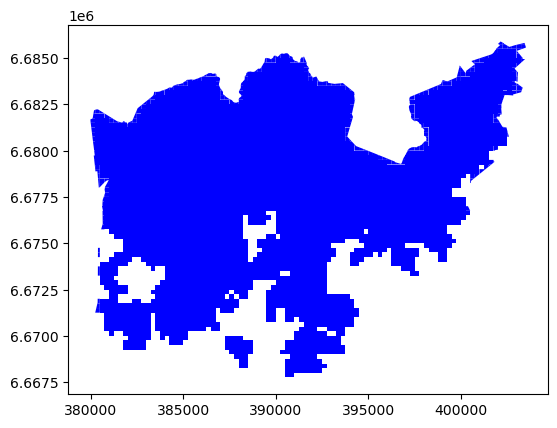

In [11]:
intersection.plot(color='b')

As a result, we now have only those grid cells that intersect with the Helsinki
borders. If you look closely, you can also observe that **the grid cells are
clipped based on the boundary.**

- Whatabout the data attributes? Let's see what we have:

In [12]:
intersection.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750, 402003.328 66857..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250 6685750, 402250 6685834.729, ..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750, 403243.781 66857..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250 6685750, 403250 6685774.119, ..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500, 402000 6685592.1..."


As we can see, due to the overlay analysis, the dataset contains the attributes
from both input layers.

Let's save our result grid as a GeoPackage.

In [ ]:
intersection.to_file(
    DATA_DIRECTORY / "intersection.gpkg",
    layer="travel_time_matrix_helsinki_region"
)

There are many more examples for different types of overlay analysis in
[Geopandas documentation](http://geopandas.org/set_operations.html) where you
can go and learn more.

> **Reading and Writing GeoPackages with Multiple Layers**  
> 
> GeoPackages are versatile spatial data formats that can store multiple layers in a single file. Here's how you can work with them using Python and GeoPandas:
> 
> ### Writing Multiple Layers to a GeoPackage
> Use the `to_file` method with the `layer` parameter to specify the name of each layer:
> ```python
> import geopandas as gpd
> 
> # Example: Writing two layers
> gdf1.to_file("example.gpkg", layer="layer1", driver="GPKG")
> gdf2.to_file("example.gpkg", layer="layer2", driver="GPKG")
> ```
> 
> ### Reading Multiple Layers from a GeoPackage
> List all available layers using `fiona` and then load specific ones:
> ```python
> import geopandas as gpd
> import fiona
> 
> # List layers in the GeoPackage
> layers = fiona.listlayers("example.gpkg")
> print(layers)  # Output: ['layer1', 'layer2']
> 
> # Read a specific layer
> gdf = gpd.read_file("example.gpkg", layer="layer1")
> ```
> 
> ### Key Notes
> - GeoPackages use the `GPKG` driver.
> - They are ideal for combining multiple spatial datasets into a single file.
> - It is a good habit to specify the layer name when working with multiple layers.
> 
> For more details, see the [GeoPandas documentation](https://geopandas.org/).
